In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from scipy.stats import norm,gaussian_kde

#loading stuff

# last_year_guesses = pd.read_csv("../data_files/MUDE_23-24_guesses.txt", sep='\t')
# last_year_guesses['Predicted Break up'] = pd.to_datetime(last_year_guesses['Predicted Break up'], errors='coerce')
# last_year_guesses['decimal time'] =last_year_guesses['Predicted Break up'].dt.hour +last_year_guesses['Predicted Break up'].dt.minute / 60
# last_year_guesses.info()

past_break_up_dates = pd.read_csv('./data/breakup_dates.csv')
past_break_up_dates['Break up dates'] = pd.to_datetime(past_break_up_dates['Break up dates'], errors='coerce')
past_break_up_dates['decimal time'] =past_break_up_dates['Break up dates'].dt.hour +past_break_up_dates['Break up dates'].dt.minute / 60
past_break_up_dates.info()


fake_2025_predictions = pd.read_csv('./data/mude_guesses.txt',sep='\t')
fake_2025_predictions['Prediction'] = pd.to_datetime(fake_2025_predictions['Prediction'], errors='coerce')
fake_2025_predictions['decimal time'] =fake_2025_predictions['Prediction'].dt.hour +fake_2025_predictions['Prediction'].dt.minute / 60
fake_2025_predictions.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Break up dates  107 non-null    datetime64[ns]
 1   decimal time    107 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            60 non-null     object        
 1   Student Number  60 non-null     int64         
 2   Group           60 non-null     object        
 3   Prediction      60 non-null     datetime64[ns]
 4   decimal time    60 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.5+ KB


In [32]:



def plot_date_time_distribution(df_1: pd.DataFrame,
                                datetime_col_1: str,
                                decimal_time_col_1: str,
                                df: pd.DataFrame, 
                                datetime_col: str,
                                decimal_time_col: str,
                                estimator: str,
                                title: str | None,
                                dayofyear: bool = True,
                                plot_size: tuple = (15, 10)) -> plt.Figure:
    """
    Scatter plot of (datetime_col, decimal_time_col), and density plot of (decimal_time_col) and (datetime_col).
    Option to use day of the year for datetime on x-axis.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    datetime_col : str
        Column name containing the datetime values.
    decimal_time_col : str
        Column name containing the decimal time values.
    estimator : str 
        Estimator to use for the density plot. Options are 'mle' (maximum likelihood), 'mm' (moments).
    title : str, optional
        Title of the plot. The default is None.
    dayofyear : bool, optional
        Whether to plot the x-axis as day of the year. Default is False.
    plot_size : tuple, optional
        Size of the plot. The default is (15, 10).
    
    Returns
    -------
    plt.Figure
        Figure object containing the plots.
    
    """
    fig, axs = plt.subplots(2, 2, figsize=plot_size, gridspec_kw={'width_ratios': [1, 6], 'height_ratios': [4, 1]})

    # Scatter plot in top right corner (axs[0,1])
    if dayofyear:
        x_values_1 = df_1[datetime_col_1].dt.dayofyear
        x_values = df[datetime_col].dt.dayofyear
        axs[0, 1].set_xlabel('Day of Year')
        x_ticks = np.arange(df[datetime_col].dt.dayofyear.min(), df[datetime_col].dt.dayofyear.max() + 1, 5)
        axs[0, 1].set_xticks(x_ticks)
    else:
        x_values = df[datetime_col]
        axs[0, 1].set_xlabel('Date (Month-Day)')
        axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axs[0, 1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    axs[0, 1].scatter(x_values_1, df_1[decimal_time_col_1],
                      color='red', label='2025 Predictions',
                      edgecolors='black', linewidths=1.0)

    axs[0, 1].scatter(x_values, df[decimal_time_col],
                      color='gray', label='Historic Breakup',
                      edgecolors='black', linewidths=1.0)

    axs[0, 1].set_ylabel('Time (Decimal)')
    axs[0, 1].set_title(title)

    mean_x = x_values.mean()
    mean_y = df[decimal_time_col].mean()

    axs[0, 1].plot(mean_x, mean_y, '+', markersize=10, color='grey')
    axs[0, 1].axvline(x=mean_x, color='gray', linestyle='--')  # Vertical line
    axs[0, 1].axhline(y=mean_y, color='gray', linestyle='--')  # Horizontal line
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    #axs[0, 1].set_ylim([0,24])


    # Density plot for datetime_col (Day of year or actual date) in position (1, 1)
    if dayofyear:
        x_fit_values = df[datetime_col].dt.dayofyear
        mu, std = norm.fit(x_fit_values, method=estimator)
        x_values_density = np.linspace(df[datetime_col].dt.dayofyear.min(), df[datetime_col].dt.dayofyear.max(), 500)
        axs[0, 1].set_xlim([90,160])
        axs[1, 1].set_xlim([90,160])
    else:
        x_fit_values = df[datetime_col].dt.dayofyear
        mu, std = norm.fit(df[datetime_col].dt.dayofyear, method=estimator)
        x_values_density = np.linspace(df[datetime_col].dt.dayofyear.min(), df[datetime_col].dt.dayofyear.max(), 500)

        # qligning x-axis limits
        x_lim = axs[0, 1].get_xlim()

        # Convert the x-axis limits from matplotlib's numeric format to datetime
        x_lim_dt = [mdates.num2date(x) for x in x_lim]

        # Apply the same x-axis limits to axs[1, 1]
        axs[1, 1].set_xlim(x_lim_dt)
        
    y_norm = norm.pdf(x_values_density, mu, std)
    axs[1, 1].hist(x_fit_values, bins='auto', density=True, alpha=0.5, color='gray', label='Histogram')
    axs[1, 1].plot(x_values_density, y_norm, label=f"Norm {estimator} estimate", color='blue')
    df[datetime_col].dt.dayofyear.plot(kind='kde', ax=axs[1, 1], color='red', alpha=0.3, label='KDE estimate')
    axs[1, 1].set_ylabel('Density')
    axs[1, 1].set_yticklabels([])  # Remove y-axis labels
    axs[1, 1].invert_yaxis()
    axs[1, 1].legend()
    
    #axs[1, 1].set_ylim([0,24])

    # Density plot for decimal time in position (0, 0) (rotated)
    mu, std = norm.fit(df[decimal_time_col], method=estimator)
    x_values_time = np.linspace(df[decimal_time_col].min(), df[decimal_time_col].max(), 500)
    y_norm_time = norm.pdf(x_values_time, mu, std)

    hist_values, bins = np.histogram(df[decimal_time_col], bins='auto', density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    kde = gaussian_kde(df[decimal_time_col])
    kde_values = kde(x_values_time)

    axs[0, 0].barh(bin_centers, hist_values, height=np.diff(bins), alpha=0.5, color='gray', label='Histogram')
    axs[0, 0].plot(kde_values, x_values_time, label='KDE Estimate', color='red', alpha=0.3)
    axs[0, 0].plot(y_norm_time, x_values_time, label=f"Norm {estimator} estimate", color='blue')
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_ylim([0,24])
    axs[0, 0].invert_xaxis()
    axs[0, 0].legend()

    # Remove ticks from side plots
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    # Hide the empty subplot
    axs[1, 0].axis('off') # add bivarite normal? are date/time correlated? at normal break up dates, yes,in tails less so

    plt.tight_layout()  # Adjust layout to prevent overlapping
    return fig


> using the date MM/DD instead of dayofyear, the axis of the scatter and distribution are not align, fix this

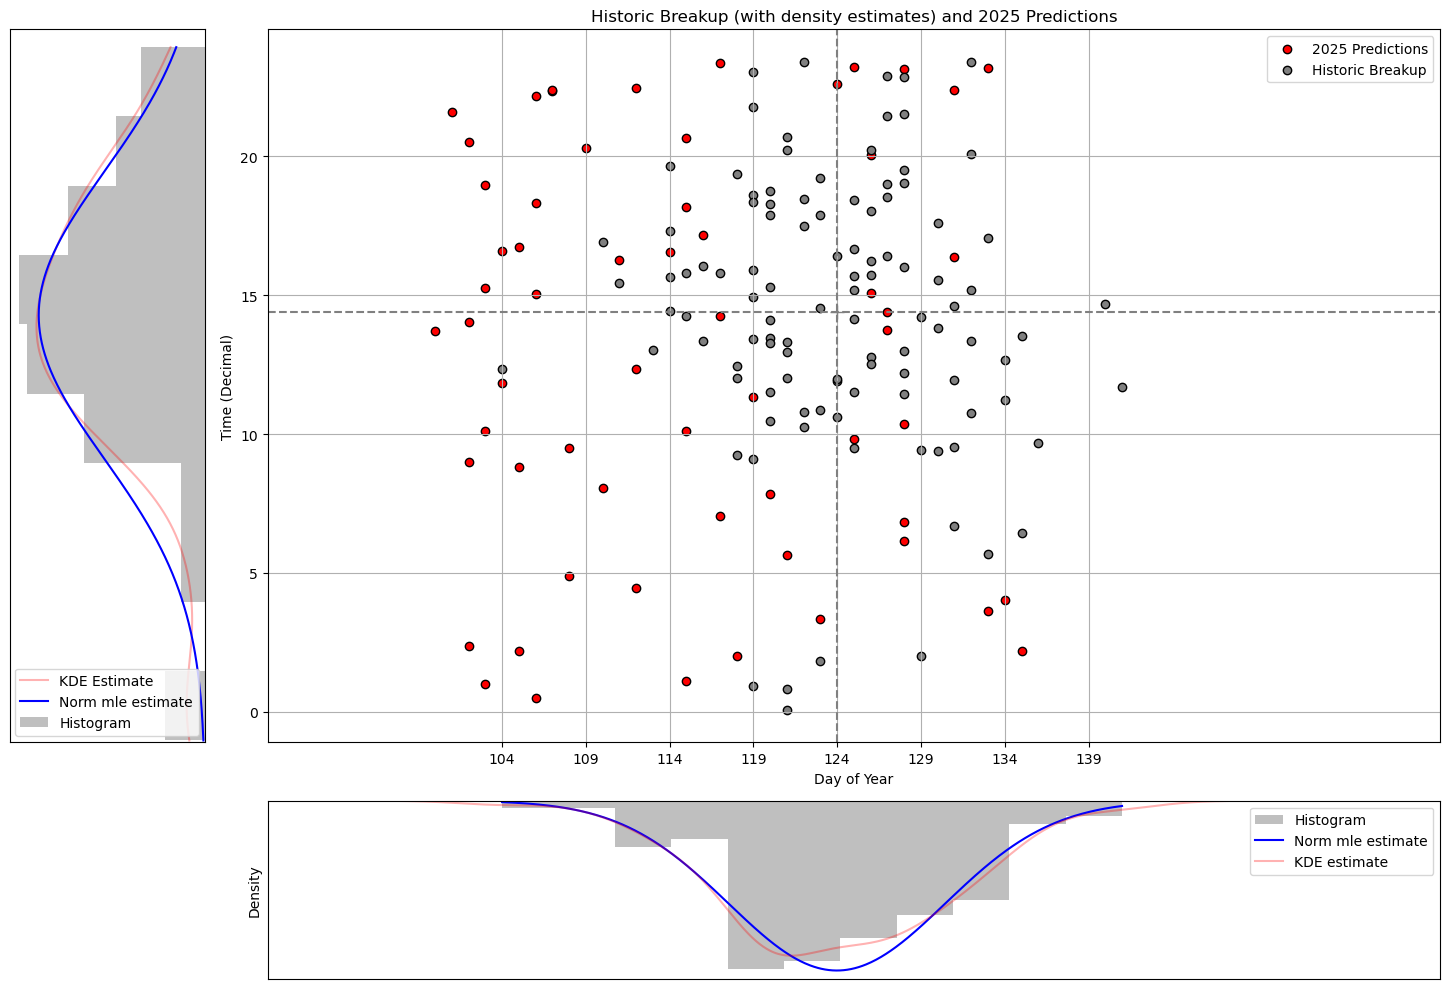

In [35]:
# if plot the historic break up dates we need to pass the day of the year as the x-axis otherwise, using the date makes the plt unreadable (dataa spams mulitple deades)
fig = plot_date_time_distribution(fake_2025_predictions, 'Prediction', 'decimal time',
                            past_break_up_dates, 'Break up dates', 'decimal time',
                            estimator='mle',
                            title='Historic Breakup (with density estimates) and 2025 Predictions',
                            dayofyear=True);

In [38]:
fig.savefig('./2025_predictions.svg')